In [2]:
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.layers import Reshape, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import numpy as np
from PIL import Image
import os
from matplotlib import pyplot as plt
import cv2

%matplotlib inline

In [3]:
def one_hot_encode(folder_name):
    num_label = float(folder_name)
    
    lst = [0]*11
    index = int(num_label/10)
    if index > len(lst)-1:
        index = len(lst)-1
    lst[index] = 1
    return lst
    

def one_hot_decode(encoding):
    axis = 1 if len(encoding) == 1 else 0
    index = int(np.argmax(encoding, axis=axis))
    return '{}-{}'.format(index*10,index*10+10)

In [4]:
#Import UTKface aligned & cropped dataset from local folder

X = []
labels = []
DATA_PATH = 'crop_part1'

#!find . -name "*.DS_Store" -type f -delete

# for each image
for image in os.listdir(DATA_PATH):
    # open image and load array data
    try:
        file_path = DATA_PATH + '/' + image
        img = Image.open(file_path)
        img.load()
        img_data = np.asarray(img, dtype=np.int16)
        img_resized = cv2.resize(img_data,(224,224))
        # add image to dataset
        X.append(img_resized)
        # get age from image file name. Age is the first part of the filename, divided by "_"
        age = str.split(image,'_')[0]
        # convert age to one hot encoding
        label = one_hot_encode(age)
        # add label to labels
        labels.append(np.array(label))
    except:
        None # do nothing if couldn't load file
X = np.asarray(X)
print(X.shape)
labels = np.array(labels)

(9780, 224, 224, 3)


(224, 224, 3)
[0 0 1 0 0 0 0 0 0 0 0]
age:  20-30


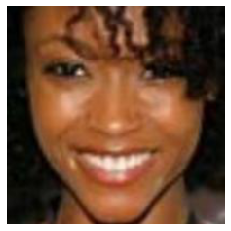

In [5]:
imnum = 900
print(X[imnum].shape)
print(labels[imnum])
print('age: ', one_hot_decode(labels[imnum]))

plt.imshow(X[imnum], interpolation='nearest')
plt.axis('off')
plt.show()

In [6]:
# normalize values
X = X/255

In [7]:
#Divide images and labels into training and testing sets

temp = list(zip(X, labels))
np.random.shuffle(temp)
X, labels = zip(*temp)
X, labels = np.asarray(X), np.asarray(labels)

# proportion to use for training
PROP_TRAIN = 0.7
# number to use for training
NUM_TRAIN = int(len(X) * PROP_TRAIN)

#divide all images into training and testing images
images_train, images_test = X[:NUM_TRAIN], X[NUM_TRAIN:]
#same for corresponding labels
labels_train, labels_test = labels[:NUM_TRAIN], labels[NUM_TRAIN:]

In [8]:
# Reshaping the arrays
# Expand the array by inserting a new axis at the specified position.

#images_train = np.expand_dims(images_train, axis=3)
#images_test = np.expand_dims(images_test, axis=3)

In [9]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# load base model
base_model = VGG16(weights='imagenet',include_top=False,input_shape = (224,224,3))

# Freeze base model
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4096, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(11, activation = 'softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dense_2 (Dense)              (None, 11)                5643      
Total params: 119,582,539
Trainable params: 104,867,851
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
#img = images_train[100]
#x = np.resize(x,[224,224,3])
#print(x.shape)
#img = np.expand_dims(img, axis=0)
#print(img.shape)

In [11]:
history = model.fit(images_train, labels_train, epochs = 2, batch_size = 32, validation_data = (images_test, labels_test))

2021-12-12 15:18:02.314436: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
214/214 [==============================] - 1304s 6s/step - loss: 1.8980 - accuracy: 0.3409 - val_loss: 1.5391 - val_accuracy: 0.4472
Epoch 2/2
214/214 [==============================] - 1264s 6s/step - loss: 1.5290 - accuracy: 0.4467 - val_loss: 1.3813 - val_accuracy: 0.4768


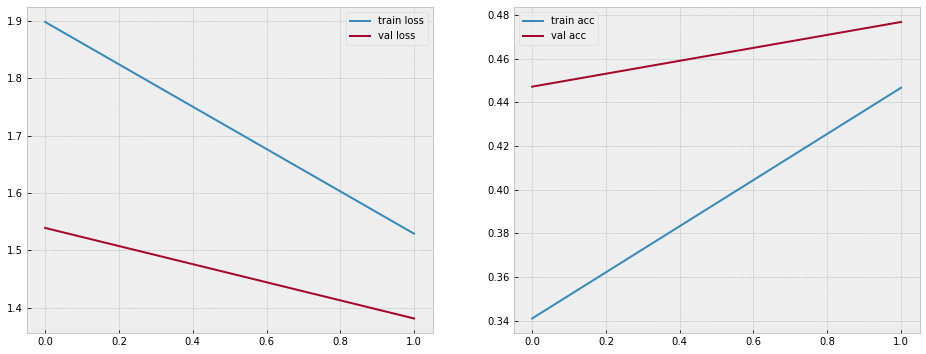

In [12]:
# Show loss and accuracy graphs

plt.style.use('bmh')
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(history.history['loss'], label='train loss')
ax[0].plot(history.history['val_loss'], label='val loss')
ax[0].legend()
ax[1].plot(history.history['accuracy'], label='train acc')
ax[1].plot(history.history['val_accuracy'], label='val acc')
ax[1].legend()

predicted age:  0-10
true age:  10-20


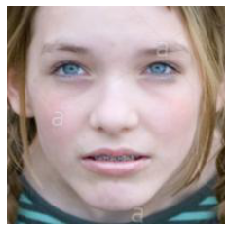

predicted age:  0-10
true age:  0-10


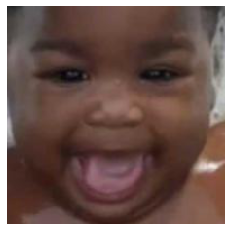

predicted age:  0-10
true age:  50-60


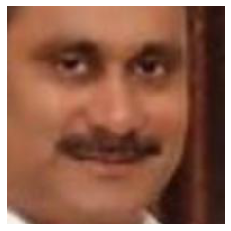

predicted age:  0-10
true age:  20-30


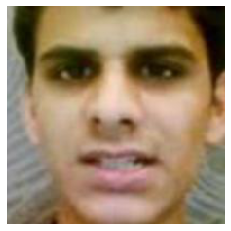

predicted age:  50-60
true age:  70-80


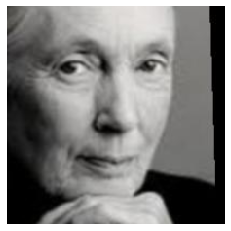

In [103]:
from random import randint

for i in range(5):
    predict_num = randint(0, len(images_test)-1)

    pred_img = np.expand_dims(images_test[predict_num], axis = 0)

    predictions = model.predict(pred_img)

    print('predicted age: ', one_hot_decode(predictions))
    print('true age: ', one_hot_decode(labels_test[predict_num]))

    plt.imshow(images_test[predict_num], interpolation='nearest')
    plt.axis('off')
    plt.show()

In [250]:
from tensorflow import math
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = model.predict(images_test)
pred = np.argmax(y_pred, axis=1)
true = labels_test
labels_num = len(labels[0])

cm = confusion_matrix(np.argmax(true, axis=1), pred, labels = list(i for i in range(labels_num)))

categories = list('{}-{}'.format(i*10,i*10+10) for i in range(labels_num))

df_cm = pd.DataFrame(cm, index = [i for i in categories],
                  columns = categories)
plt.figure(figsize = (15,10))

ax = sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

KeyboardInterrupt: 

Text(0.5, 72.5, 'Predicted label')

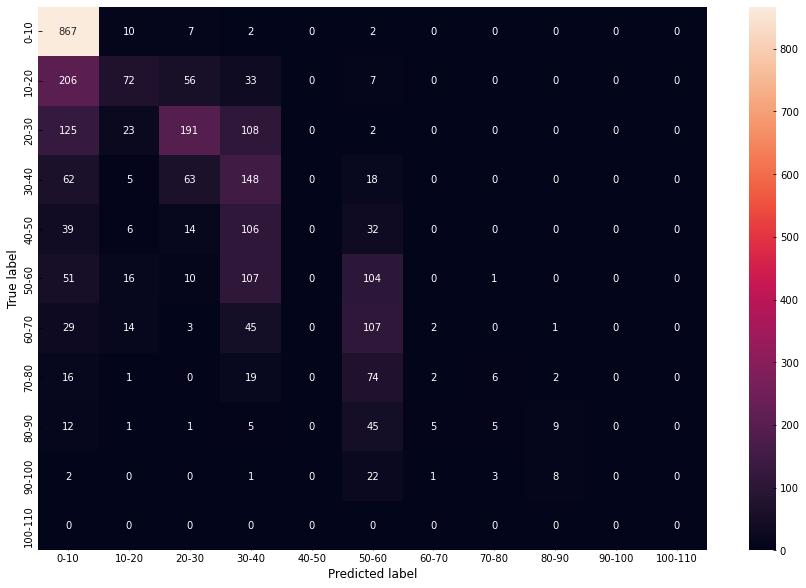

In [249]:
import seaborn as sn
import pandas as pd

categories = list('{}-{}'.format(i*10,i*10+10) for i in range(11))

df_cm = pd.DataFrame(cm, index = [i for i in categories],
                  columns = categories)
plt.figure(figsize = (15,10))

ax = sn.heatmap(df_cm, annot=True, fmt='g')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')